# HDFS_v1

In [18]:
!pip install tqdm

     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.7 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 57.7/57.7 kB 1.0 MB/s eta 0:00:00
  Using cached colorama-0.4.6-py2.py3-none-any.whl.metadata (17 kB)
   ---------------------------------------- 0.0/78.5 kB ? eta -:--:--
   ---------------------------------------- 78.5/78.5 kB 4.6 MB/s eta 0:00:00
Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)



[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
import time
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

## Drain

Рассмотрим метод Drain. Ниже приведен код для него.

Информация о методе взята отсюда: [Drain: An Online Log Parsing Approach with Fixed
Depth Tree](https://jiemingzhu.github.io/pub/pjhe_icws2017.pdf)  
Сам пример кода взят отсюда: [logparser/Drain](https://github.com/logpai/logparser/blob/main/logparser/Drain/Drain.py)  
Код немного изменен, но в основном всё бралось оттуда. Переписал просто для себя, чтобы лучше разобраться

In [39]:
class Node:
    def __init__(self, child_id=None, depth=0, token=None):
        """
        Класс для узла дерева
        :param child_id: id всех лепестков дерева
        :param depth: уровень, на котором находится узел
        :param token: значение узла
        """
        if child_id is None:
            child_id = {}
        self.child_id = child_id
        self.depth = depth
        self.token = token


class LogCluster:
    def __init__(self, log_template='', log_id=None):
        """
        Кластер для хранения схожих логов
        :param log_template: Шаблон лога
        :param log_id: id строк логов с данным шаблоном
        """
        if log_id is None:
            log_id = []
        self.log_template = log_template
        self.log_id = log_id


class DrainParser:
    def __init__(self,
                 log_format,
                 input_dir,
                 output_dir,
                 depth=4,
                 similarity=0.4,
                 max_child=100,
                 save_parameters=False,
                 regex={},
                 ):
        """
        Класс для инициализации парсинга логов с помощью метода Drain
        :param log_format: Формат лога
        :param input_dir: Директория, где находится лог-файл
        :param output_dir: Директория, куда будут записаны результаты
        :param depth: максимальная глубина дерева
        :param similarity: схожесть сообщений в логах
        :param max_child: максимальное количество лепестков дерева с уровня 2 и ниже
        """
        self.log_format = log_format
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.depth = depth - 2
        self.similarity = similarity
        self.max_child = max_child
        self.root_node = Node()
        self.log_df = pd.DataFrame()
        self.save_parameters = save_parameters
        self.regex = regex

    def parse(self, log_name: str) -> None:
        headers, log_format_regex = self.generate_log_format_regex()
        self.log_df = self.load_to_dataframe(log_name, headers, log_format_regex)

        list_clusters = []

        # count = 0

        time_start = time.perf_counter()

        for idx, line in tqdm(self.log_df.iterrows()):
            # len_df = len(self.log_df)

            log_id = line['log_id']
            # list_message = self.preprocess(line['Content']).strip().split()
            list_message = list(filter(lambda x: x != '', re.split(r'[\s=:,]', self.preprocess(line['Content']).strip())))

            match_cluster = self.tree_search(list_message)

            if match_cluster is None:
                new_cluster = LogCluster(list_message, [log_id])
                list_clusters.append(new_cluster)
                self.add_cluster_to_tree(new_cluster)

            else:
                new_template = self.get_template(list_message, match_cluster.log_template)
                match_cluster.log_id.append(log_id)
                if ' '.join(new_template) != ' '.join(match_cluster.log_template):
                    match_cluster.log_template = new_template

            # count += 1
            # if count % 1000 == 0 or count == len(self.log_df):
            #     print(
            #         "Processed {0:.2f}% of log lines.".format(
            #             count * 100.0 / len(self.log_df)
            #         )
            #     )

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        print(f'\nTime taken: {time.perf_counter() - time_start:.4f} seconds')

        self.save_results(list_clusters, log_name)

    def load_to_dataframe(self, log_name: str, headers: list[str], log_format_regex: re.Pattern[str]) -> pd.DataFrame:
        """
        Загрузка логов в датафрейм
        :param log_name: Наименование файла логов
        :param headers: Заголовки датафрейма
        :param log_format_regex: Регулярное выражение для парсинга строк
        :return: pd.DataFrame()
        """
        df_dict = {header: [] for header in headers}
        skipped_lines = 0

        print('Starting loading logs to dataframe')

        with open(Path(self.input_dir, log_name), 'r', encoding='utf-8') as f:
            for line in tqdm(f.readlines()):
                # В случае отсутствия одного из параметров, сообщение будет пропущено
                try:
                    match = re.match(log_format_regex, line.strip())
                    for header in df_dict:
                        df_dict[header].append(match.group(header).strip())
                except AttributeError:
                    skipped_lines += 1

        df = pd.DataFrame(df_dict)
        df.insert(0, 'log_id', [i for i in range(1, len(df) + 1)])

        print(f'Dataframe was loaded, {skipped_lines} messages was skipped, due to missing parameter in log message')

        return df

    def generate_log_format_regex(self) -> (list[str], re.Pattern[str]):
        """
        Генерация регулярного выражения для парсинга строк
        :return: headers: list, log_format_regex: regular expression
        """
        headers = []
        log_format_regex = ''
        split_log_format = re.split(r'(<[^<>]+>)', self.log_format)

        for i, name in enumerate(split_log_format):
            if i % 2 == 0:
                log_format_regex += re.sub(r'\s+', '\\\s+', name)
            else:
                header = name.strip('<>')
                headers.append(header)
                log_format_regex += rf'(?P<{header}>.+?)'

        log_format_regex = re.compile('^' + log_format_regex + '$')

        return headers, log_format_regex

    def preprocess(self, string):
        for symbol, rex in self.regex.items():
            string = re.sub(rex, symbol, string)
        return string
        
    def tree_search(self, sequence: list[str]) -> LogCluster or None:
        """
        Поиск наиболее подходящего кластера по дереву
        :param sequence: Список слов в сообщении
        :return: LogCluster or None
        """
        len_sequence = len(sequence)
        matched_cluster = None

        if len_sequence not in self.root_node.child_id:
            return matched_cluster

        parent_node = self.root_node.child_id[len_sequence]
        current_depth = 1
        for token in sequence:
            if current_depth >= self.depth or current_depth > len_sequence:
                break

            if token in parent_node.child_id:
                parent_node = parent_node.child_id[token]
            elif "<*>" in parent_node.child_id:
                parent_node = parent_node.child_id["<*>"]
            else:
                return matched_cluster
            current_depth += 1

        possible_cluster = parent_node.child_id

        matched_cluster = self.find_match(possible_cluster, sequence)

        return matched_cluster

    def find_match(self, cluster: list[LogCluster], sequence: list[str]) -> LogCluster or None:
        """
        Нахождение наиболее схожего кластера
        :param cluster: список из LogCluster
        :param sequence: Список слов в сообщении
        :return: LogCluster or None
        """
        max_similarity = 0
        max_number_of_similar_params = 0
        matched_cluster = None

        for cl in cluster:
            similarity, number_of_parameters = self.check_similarity(cl.log_template, sequence)
            if (similarity > max_similarity or
                    (similarity == max_similarity and number_of_parameters > max_number_of_similar_params)):
                max_similarity = similarity
                max_number_of_similar_params = number_of_parameters
                matched_cluster = cl

        if max_similarity < self.similarity:
            return None

        return matched_cluster

    def check_similarity(self, template: list[str], sequence: list[str]) -> (float, int):
        """
        Проверка схожести c шаблоном
        :param template: шаблон
        :param sequence: список слов в сообщении
        :return: схожесть; количество параметров, отмеченных <*>
        """
        similar_tokens, number_of_parameters = 0, 0
        for token_1, token_2 in zip(template, sequence):
            if token_1 == '<*>':
                number_of_parameters += 1
            elif token_1 == token_2:
                similar_tokens += 1

        similarity = similar_tokens / len(sequence)

        return similarity, number_of_parameters

    def add_cluster_to_tree(self, cluster: LogCluster) -> None:
        """
        Добавление кластера к дереву
        :param cluster: LogCluster
        :return: None
        """
        len_sequence = len(cluster.log_template)
        if len_sequence not in self.root_node.child_id:
            first_layer_node = Node(depth=1, token=len_sequence)
            self.root_node.child_id[len_sequence] = first_layer_node
        else:
            first_layer_node = self.root_node.child_id[len_sequence]

        parent_node = first_layer_node

        current_depth = 1
        for token in cluster.log_template:
            if current_depth >= self.depth or current_depth > len_sequence:
                if len(parent_node.child_id) == 0:
                    parent_node.child_id = [cluster]
                else:
                    parent_node.child_id.append(cluster)
                break

            if token not in parent_node.child_id:
                current_number_of_child = len(parent_node.child_id)

                if not any(char.isdigit() for char in token):
                    if '<*>' in parent_node.child_id:
                        if current_number_of_child < self.max_child:
                            new_node = Node(depth=current_depth + 1, token=token)
                            parent_node.child_id[token] = new_node
                            parent_node = new_node
                        else:
                            parent_node = parent_node.child_id['<*>']
                    else:
                        if current_number_of_child + 1 < self.max_child:
                            new_node = Node(depth=current_depth + 1, token=token)
                            parent_node.child_id[token] = new_node
                            parent_node = new_node
                        elif current_number_of_child + 1 == self.max_child:
                            new_node = Node(depth=current_depth + 1, token='<*>')
                            parent_node.child_id['<*>'] = new_node
                            parent_node = new_node
                else:
                    if '<*>' in parent_node.child_id:
                        parent_node = parent_node.child_id['<*>']
                    else:
                        new_node = Node(depth=current_depth + 1, token='<*>')
                        parent_node.child_id['<*>'] = new_node
                        parent_node = new_node
            else:
                parent_node = parent_node.child_id[token]

            current_depth += 1

    def get_template(self, new_sequence: list[str], old_sequence: list[str]) -> list[str]:
        """
        Создание шаблона сообщения
        :param new_sequence: Новое сообщение в текущем логе
        :param old_sequence: Старое сообщение, которое хранится в шаблоне кластера
        :return: Новый шаблон
        """
        new_template = []

        for word_1, word_2 in zip(new_sequence, old_sequence):
            if word_1 == word_2:
                new_template.append(word_1)
            else:
                new_template.append('<*>')

        return new_template

    def save_results(self, clusters: list[LogCluster], log_file: str) -> None:
        """
        Сохранение результатов в формате csv
        :param clusters: все добавленные кластеры
        :param log_file: имя файла
        :return: None
        """
        log_templates = [pd.NA] * len(self.log_df)
        log_templates_id = [pd.NA] * len(self.log_df)
        df_events = []
        id_counter = 1

        print('Starting preparing results to save them to .csv file.')

        for cluster in clusters:
            template = ' '.join(cluster.log_template)
            occurrence = len(cluster.log_id)
            hex_id = id_counter # Вариант с хешем int(str(hash(template))[:8])
            for idx in cluster.log_id:
                idx -= 1
                log_templates[idx] = template
                log_templates_id[idx] = hex_id
            df_events.append([hex_id, template, occurrence])
            id_counter += 1

        self.log_df['Event_id'] = log_templates_id
        self.log_df['Event_template'] = log_templates
        if self.save_parameters:
            self.log_df['parameters'] = self.log_df.apply(self.get_parameter_list, axis=1)

        print('Results was prepared.')
        print(f'Saving dataframe to {Path(self.output_dir, log_file + '_structured.csv')}')

        self.log_df.to_csv(Path(self.output_dir, log_file + '_structured.csv'), index=False)

        print(f'Saving templates to {Path(self.output_dir, log_file + '_templates.csv')}')

        event_df = pd.DataFrame(df_events, columns=['Event_id', 'Event_template', 'Occurrence'])
        event_df.sort_values(by='Event_id').to_csv(Path(self.output_dir, log_file + '_templates.csv'), index=False)

    def get_parameter_list(self, row) -> list:
        """
        Для создания столбца параметров, которые скрываются за <*>
        :param row: строка из DataFrame
        :return: список подставляемых значений
        """
        result_row = []
        if '<*>' not in row['Event_template']:
            return result_row

        token_list = list(filter(lambda x: x != '', re.split(r'[\s=:,]', row['Content'].strip())))
        template_list = row['Event_template'].split()

        for i, template_token in enumerate(template_list):
            if template_token == '<*>':
                result_row.append(token_list[i])

        # Вариант с регулярками плохо работает,
        # так как в этом случае разделение первоначальной строки надо делать только по пробелам

        # regex = re.sub(r'([^A-Za-z0-9])', r'\\\g<1>', row['Event_template'])
        # regex = re.sub(r'\\\s+', r'\\s+', regex)
        # regex = '^' + re.sub(r'\\<\\\*\\>', r'(.*?)', regex) + '$'
        # result_row = re.findall(regex, row['Content'])
        # result_row = list(result_row[0]) if isinstance(result_row[0], tuple) else [result_row[0]]

        return result_row

<>:146: SyntaxWarning: invalid escape sequence '\s'
<>:146: SyntaxWarning: invalid escape sequence '\s'
C:\Users\user\AppData\Local\Temp\ipykernel_13596\3184652496.py:146: SyntaxWarning: invalid escape sequence '\s'
  log_format_regex += re.sub(r'\s+', '\\\s+', name)


Очень часто встречаются ip-адреса с портами, поэтому их при препроцессинге заменяем на \<IP>. Схожесть строк взята 0.3, так как при большем значении начинает увеличиваться количество шаблонов, хотя они очень похожи, при 0.4 становится порядка 47, при 0.5 уже 300+.

In [40]:
inp_dir = r''
out_dir = r'templates\\drain\\'
log = r'HDFS.log'
format_log = '<Date> <Time> <Pid> <Level> <Component>: <Content>'
regex = {"<IP>": r'/?\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+'}
drain = DrainParser(format_log, inp_dir, out_dir, similarity=0.3, depth=4, max_child=100, save_parameters=False, regex=regex)
drain.parse(log)

Starting loading logs to dataframe


100%|███████████████████████████████████████████████████████████████████| 11175629/11175629 [02:00<00:00, 92650.83it/s]


Dataframe was loaded, 0 messages was skipped, due to missing parameter in log message


11175629it [16:51, 11048.86it/s]



Time taken: 1011.4810 seconds
Starting preparing results to save them to .csv file.
Results was prepared.
Saving dataframe to templates\drain\st03\HDFS.log_structured.csv
Saving templates to templates\drain\st03\HDFS.log_templates.csv


В результате работы парсера Drain получаем следующие шаблоны

In [65]:
drain_templates = pd.read_csv('templates\\drain\\HDFS.log_templates.csv')

In [66]:
drain_templates

,Event_id,Event_template,Occurrence
0,1,Receiving block <*> src <IP> dest <IP>,1723232
1,2,BLOCK* NameSystem.allocateBlock <*> <*>,575061
2,3,PacketResponder <*> for block <*> <*>,1706728
3,4,Received block <*> of size <*> from <*>,1706514
4,5,BLOCK* NameSystem.addStoredBlock blockMap upda...,1719741
5,6,Received block <*> src <IP> dest <IP> of size <*>,7097
6,7,<IP> <*> block <*> to <*>,435663
7,8,<IP> Starting thread to transfer block <*> to ...,165
8,9,BLOCK* ask <IP> to replicate <*> to datanode(s...,165
9,10,BLOCK* ask <IP> to replicate <*> to datanode(s...,6837


Наиболее часто встречающиеся шаблоны

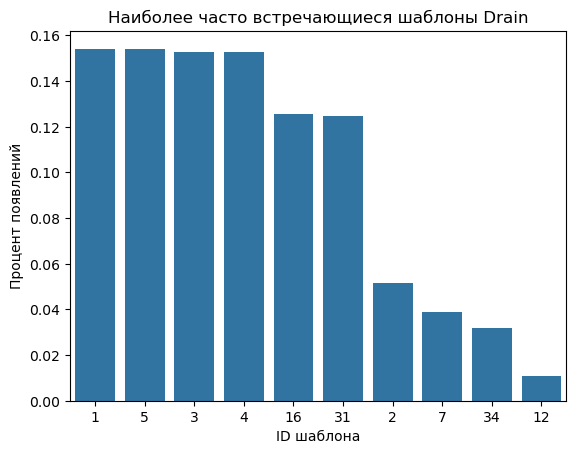

In [79]:
drain_templates_sorted = drain_templates.sort_values(by='Occurrence', ascending=False)[:10]
number_of_logs = drain_templates['Occurrence'].sum()
drain_templates_sorted['Occurrence_percentage'] = drain_templates_sorted['Occurrence'] / number_of_logs
order_drain = drain_templates_sorted['Event_id']
sns.barplot(data=drain_templates_sorted, x='Event_id', y="Occurrence_percentage", order=order_drain)
plt.title('Наиболее часто встречающиеся шаблоны Drain')
plt.xlabel('ID шаблона')
plt.ylabel('Процент появлений')
plt.show()

## Spell

Ниже дан код для парсера по алгоритму Spell.  
Статья о самом алгоритме: [Spell: Streaming Parsing of System Event Logs](https://www.cs.utah.edu/%7Elifeifei/papers/spell.pdf)  
Сам пример кода взят отсюда: [logparser/Spell](https://github.com/logpai/logparser/blob/main/logparser/Spell/Spell.py)  
Код немного изменен, но в основном всё бралось оттуда.

In [62]:
class LCSObject:
    """Class object to store a log group with the same template"""

    def __init__(self, logTemplate="", logIDL=[]):
        self.logTemplate = logTemplate
        self.logIDL = logIDL


class Node:
    """A node in prefix tree data structure"""

    def __init__(self, token="", templateNo=0):
        self.logClust = None
        self.token = token
        self.templateNo = templateNo
        self.childD = dict()


class Spell:
    """LogParser class

    Attributes
    ----------
        path : the path of the input file
        logName : the file name of the input file
        savePath : the path of the output file
        tau : how much percentage of tokens matched to merge a log message
    """

    def __init__(
        self,
        indir="./",
        outdir="./result/",
        log_format=None,
        tau=0.5,
        rex=[],
        keep_para=True,
    ):
        self.path = indir
        self.logName = None
        self.savePath = outdir
        self.tau = tau
        self.logformat = log_format
        self.df_log = None
        self.rex = rex
        self.keep_para = keep_para

    def LCS(self, seq1, seq2):
        lengths = [[0 for j in range(len(seq2) + 1)] for i in range(len(seq1) + 1)]
        # row 0 and column 0 are initialized to 0 already
        for i in range(len(seq1)):
            for j in range(len(seq2)):
                if seq1[i] == seq2[j]:
                    lengths[i + 1][j + 1] = lengths[i][j] + 1
                else:
                    lengths[i + 1][j + 1] = max(lengths[i + 1][j], lengths[i][j + 1])

        # read the substring out from the matrix
        result = []
        lenOfSeq1, lenOfSeq2 = len(seq1), len(seq2)
        while lenOfSeq1 != 0 and lenOfSeq2 != 0:
            if lengths[lenOfSeq1][lenOfSeq2] == lengths[lenOfSeq1 - 1][lenOfSeq2]:
                lenOfSeq1 -= 1
            elif lengths[lenOfSeq1][lenOfSeq2] == lengths[lenOfSeq1][lenOfSeq2 - 1]:
                lenOfSeq2 -= 1
            else:
                assert seq1[lenOfSeq1 - 1] == seq2[lenOfSeq2 - 1]
                result.insert(0, seq1[lenOfSeq1 - 1])
                lenOfSeq1 -= 1
                lenOfSeq2 -= 1
        return result

    def len_lcs(self, seq1, seq2):
        if len(seq1) < len(seq2):
            seq1, seq2 = seq2, seq1

        len_seq1 = len(seq1)
        len_seq2 = len(seq2)

        lcs = [0 for _ in range(len_seq2 + 1)]
        d = 0

        for i in range(len_seq1):
            for j in range(len_seq2):
                tmp = lcs[j + 1]
                if seq1[i] == seq2[j]:
                    lcs[j + 1] = d + 1
                else:
                    lcs[j + 1] = max(lcs[j + 1], lcs[j])
                d = tmp
        return lcs[-1]

    def SimpleLoopMatch(self, logClustL, seq):
        for logClust in logClustL:
            if float(len(logClust.logTemplate)) < 0.5 * len(seq):
                continue
            # Check the template is a subsequence of seq (we use set checking as a proxy here for speedup since
            # incorrect-ordering bad cases rarely occur in logs)
            token_set = set(seq)
            if all(
                token in token_set or token == "<*>" for token in logClust.logTemplate
            ):
                return logClust
        return None

    def PrefixTreeMatch(self, parentn, seq, idx):
        retLogClust = None
        length = len(seq)
        for i in range(idx, length):
            if seq[i] in parentn.childD:
                childn = parentn.childD[seq[i]]
                if childn.logClust is not None:
                    constLM = [w for w in childn.logClust.logTemplate if w != "<*>"]
                    if float(len(constLM)) >= self.tau * length:
                        return childn.logClust
                else:
                    return self.PrefixTreeMatch(childn, seq, i + 1)

        return retLogClust

    def LCSMatch(self, logClustL, seq):
        retLogClust = None

        maxLen = -1
        # maxlcs = []
        maxClust = None
        set_seq = set(seq)
        size_seq = len(seq)
        for logClust in logClustL:
            set_template = set(logClust.logTemplate)
            if len(set_seq & set_template) < 0.5 * size_seq:
                continue
            # lcs = self.LCS(seq, logClust.logTemplate)
            len_lcs = self.len_lcs(seq, logClust.logTemplate)
            if len_lcs > maxLen or (
                len_lcs == maxLen
                and len(logClust.logTemplate) < len(maxClust.logTemplate)
            ):
                maxLen = len_lcs
                # maxlcs = lcs
                maxClust = logClust

        # LCS should be large then tau * len(itself)
        if float(maxLen) >= self.tau * size_seq:
            retLogClust = maxClust

        return retLogClust

    def getTemplate(self, lcs, seq):
        retVal = []
        if not lcs:
            return retVal

        lcs = lcs[::-1]
        i = 0
        for token in seq:
            i += 1
            if token == lcs[-1]:
                retVal.append(token)
                lcs.pop()
            else:
                retVal.append("<*>")
            if not lcs:
                break
        if i < len(seq):
            retVal.append("<*>")
        return retVal

    def addSeqToPrefixTree(self, rootn, newCluster):
        parentn = rootn
        seq = newCluster.logTemplate
        seq = [w for w in seq if w != "<*>"]

        for i in range(len(seq)):
            tokenInSeq = seq[i]
            # Match
            if tokenInSeq in parentn.childD:
                parentn.childD[tokenInSeq].templateNo += 1
            # Do not Match
            else:
                parentn.childD[tokenInSeq] = Node(token=tokenInSeq, templateNo=1)
            parentn = parentn.childD[tokenInSeq]

        if parentn.logClust is None:
            parentn.logClust = newCluster

    def removeSeqFromPrefixTree(self, rootn, newCluster):
        parentn = rootn
        seq = newCluster.logTemplate
        seq = [w for w in seq if w != "<*>"]

        for tokenInSeq in seq:
            if tokenInSeq in parentn.childD:
                matchedNode = parentn.childD[tokenInSeq]
                if matchedNode.templateNo == 1:
                    del parentn.childD[tokenInSeq]
                    break
                else:
                    matchedNode.templateNo -= 1
                    parentn = matchedNode

    def outputResult(self, logClustL):
        templates = [0] * self.df_log.shape[0]
        ids = [0] * self.df_log.shape[0]
        df_event = []
        id_counter = 1

        print('Starting preparing results to save them to .csv file.')

        for logclust in logClustL:
            template_str = " ".join(logclust.logTemplate)
            eid = id_counter
            # eid = hashlib.md5(template_str.encode("utf-8")).hexdigest()[0:8]
            for logid in logclust.logIDL:
                logid -= 1
                templates[logid] = template_str
                ids[logid] = eid
            id_counter += 1
            df_event.append([eid, template_str, len(logclust.logIDL)])

        df_event = pd.DataFrame(
            df_event, columns=["Event_id", "Event_template", "Occurrence"]
        )

        self.df_log["Event_id"] = ids
        self.df_log["Event_template"] = templates
        if self.keep_para:
            self.df_log["parameters"] = self.df_log.apply(
                self.get_parameter_list, axis=1
            )

        print('Results was prepared.')
        print(f'Saving dataframe to {Path(self.savePath, self.logname + '_structured.csv')}')

        self.df_log.to_csv(
            os.path.join(self.savePath, self.logname + "_structured.csv"), index=False
        )

        print(f'Saving templates to {Path(self.savePath, self.logname + '_templates.csv')}')

        df_event.sort_values(by='Event_id').to_csv(
            os.path.join(self.savePath, self.logname + "_templates.csv"), index=False
        )

    def parse(self, logname):
        time_start = time.perf_counter()
        self.logname = logname
        self.load_data()
        rootNode = Node()
        logCluL = []

        # count = 0
        for idx, line in tqdm(self.df_log.iterrows()):
            logID = line["LineId"]
            logmessageL = list(
                filter(
                    lambda x: x != "",
                    re.split(r"[\s=:,]", self.preprocess(line["Content"])),
                )
            )
            constLogMessL = [w for w in logmessageL if w != "<*>"]

            # Find an existing matched log cluster
            matchCluster = self.PrefixTreeMatch(rootNode, constLogMessL, 0)

            if matchCluster is None:
                matchCluster = self.SimpleLoopMatch(logCluL, constLogMessL)

                if matchCluster is None:
                    matchCluster = self.LCSMatch(logCluL, logmessageL)

                    # Match no existing log cluster
                    if matchCluster is None:
                        newCluster = LCSObject(logTemplate=logmessageL, logIDL=[logID])
                        logCluL.append(newCluster)
                        self.addSeqToPrefixTree(rootNode, newCluster)
                    # Add the new log message to the existing cluster
                    else:
                        newTemplate = self.getTemplate(
                            self.LCS(logmessageL, matchCluster.logTemplate),
                            matchCluster.logTemplate,
                        )
                        if " ".join(newTemplate) != " ".join(matchCluster.logTemplate):
                            self.removeSeqFromPrefixTree(rootNode, matchCluster)
                            matchCluster.logTemplate = newTemplate
                            self.addSeqToPrefixTree(rootNode, matchCluster)
            if matchCluster:
                matchCluster.logIDL.append(logID)
            # count += 1
            # if count % 1000 == 0 or count == len(self.df_log):
            #     print(
            #         "Processed {0:.1f}% of log lines.".format(
            #             count * 100.0 / len(self.df_log)
            #         )
            #     )

        print(f'\nTime taken: {time.perf_counter() - time_start:.4f} seconds')

        if not os.path.exists(self.savePath):
            os.makedirs(self.savePath)

        self.outputResult(logCluL)

    def load_data(self):
        headers, regex = self.generate_logformat_regex(self.logformat)
        self.df_log = self.log_to_dataframe(
            os.path.join(self.path, self.logname), regex, headers, self.logformat
        )

    def preprocess(self, line):
        for symbol, currentRex in self.rex.items():
            line = re.sub(currentRex, symbol, line)
        return line

    def log_to_dataframe(self, log_file, regex, headers, logformat):
        """Function to transform log file to dataframe"""
        log_messages = []
        linecount = 0
        skip_line_counter = 0

        print('Starting loading logs to dataframe')

        with open(log_file, "r") as fin:
            for line in tqdm(fin.readlines()):
                line = re.sub(r"[^\x00-\x7F]+", "<NASCII>", line)
                try:
                    match = regex.search(line.strip())
                    message = [match.group(header) for header in headers]
                    log_messages.append(message)
                    linecount += 1
                except Exception as e:
                    skip_line_counter += 1
                    # print("Skip line: " + line)
        logdf = pd.DataFrame(log_messages, columns=headers)
        logdf.insert(0, "LineId", None)
        logdf["LineId"] = [i + 1 for i in range(linecount)]

        print(f'Dataframe was loaded, {skip_line_counter} messages was skipped, due to missing parameter in log message')

        return logdf

    def generate_logformat_regex(self, logformat):
        """Function to generate regular expression to split log messages"""
        headers = []
        splitters = re.split(r"(<[^<>]+>)", logformat)
        regex = ""
        for k in range(len(splitters)):
            if k % 2 == 0:
                splitter = re.sub(" +", "\\\s+", splitters[k])
                regex += splitter
            else:
                header = splitters[k].strip("<").strip(">")
                regex += "(?P<%s>.*?)" % header
                headers.append(header)
        regex = re.compile("^" + regex + "$")
        return headers, regex

    def get_parameter_list(self, row):
        template_regex = re.sub(r"<.{1,5}>", "<*>", row["EventTemplate"])
        if "<*>" not in template_regex:
            return []
        template_regex = re.sub(r"([^A-Za-z0-9])", r"\\\1", template_regex)
        template_regex = re.sub(r"\\ +", r"\\s+", template_regex)
        template_regex = "^" + template_regex.replace("\<\*\>", "(.*?)") + "$"
        parameter_list = re.findall(template_regex, row["Content"])
        parameter_list = parameter_list[0] if parameter_list else ()
        parameter_list = (
            list(parameter_list)
            if isinstance(parameter_list, tuple)
            else [parameter_list]
        )
        return parameter_list

<>:349: SyntaxWarning: invalid escape sequence '\s'
<>:364: SyntaxWarning: invalid escape sequence '\<'
<>:349: SyntaxWarning: invalid escape sequence '\s'
<>:364: SyntaxWarning: invalid escape sequence '\<'
C:\Users\user\AppData\Local\Temp\ipykernel_13596\3173767237.py:349: SyntaxWarning: invalid escape sequence '\s'
  splitter = re.sub(" +", "\\\s+", splitters[k])
C:\Users\user\AppData\Local\Temp\ipykernel_13596\3173767237.py:364: SyntaxWarning: invalid escape sequence '\<'
  template_regex = "^" + template_regex.replace("\<\*\>", "(.*?)") + "$"


In [73]:
inp_dir = r''
out_dir = r'templates\\spell\\'
log = r'HDFS.log'
format_log = '<Date> <Time> <Pid> <Level> <Component>: <Content>'
regex = {"<IP>": r'/?\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}:\d+'}
spell = Spell(indir=inp_dir, outdir=out_dir, log_format=format_log, tau=0.5, rex=regex, keep_para=False)
spell.parse(log)

Starting loading logs to dataframe


100%|███████████████████████████████████████████████████████████████████| 11175629/11175629 [02:42<00:00, 68945.89it/s]


Dataframe was loaded, 0 messages was skipped, due to missing parameter in log message


11175629it [16:28, 11305.06it/s]



Time taken: 1170.7551 seconds
Starting preparing results to save them to .csv file.
Results was prepared.
Saving dataframe to templates\spell\HDFS.log_structured.csv
Saving templates to templates\spell\HDFS.log_templates.csv


In [74]:
spell_templates = pd.read_csv('templates\spell\HDFS.log_templates.csv')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\user\AppData\Local\Temp\ipykernel_13596\2294675522.py:1: SyntaxWarning: invalid escape sequence '\s'
  spell_templates = pd.read_csv('templates\spell\HDFS.log_templates.csv')


In [75]:
spell_templates

,Event_id,Event_template,Occurrence
0,1,Receiving block <*> src <IP> dest <IP>,1723232
1,2,BLOCK* NameSystem.allocateBlock <*>,575061
2,3,PacketResponder <*> for block <*>,1706728
3,4,Received block <*> of size <*>,1713611
4,5,BLOCK* NameSystem.addStoredBlock blockMap upda...,1719741
5,6,<IP> Transmitted block blk_-160899968791986290...,4
6,7,<IP> <*> <*> <*> <*> block <*> to <*>,442695
7,8,BLOCK* ask <IP> to replicate <*> to datanode(s...,7002
8,9,Verification succeeded for <*>,120036
9,10,writeBlock <*> received exception <*>,3300


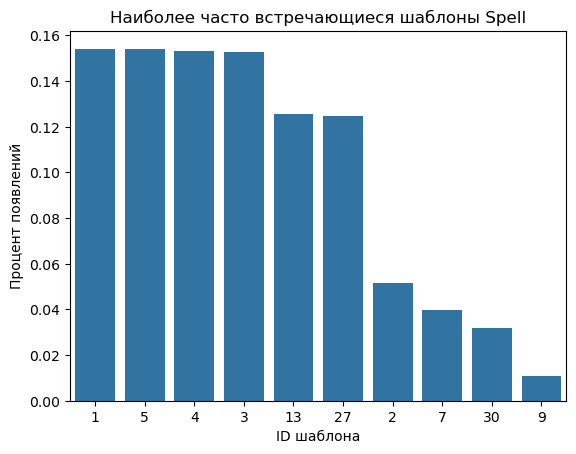

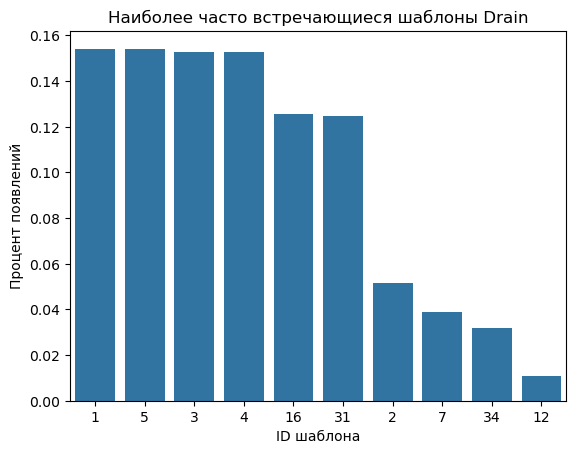

In [81]:
spell_templates_sorted = spell_templates.sort_values(by='Occurrence', ascending=False)[:10]
number_of_logs = spell_templates['Occurrence'].sum()
spell_templates_sorted['Occurrence_percentage'] = spell_templates_sorted['Occurrence'] / number_of_logs
order_spell = spell_templates_sorted['Event_id']
sns.barplot(data=spell_templates_sorted, x='Event_id', y="Occurrence_percentage", order=order_spell)
plt.title('Наиболее часто встречающиеся шаблоны Spell')
plt.xlabel('ID шаблона')
plt.ylabel('Процент появлений')
plt.show()
sns.barplot(data=drain_templates_sorted, x='Event_id', y="Occurrence_percentage", order=order_drain)
plt.title('Наиболее часто встречающиеся шаблоны Drain')
plt.xlabel('ID шаблона')
plt.ylabel('Процент появлений')
plt.show()

## Выводы

1. В результате получили два датафрейма вместе с шаблонами логов. Шаблоны логов и датафрейм сохраняются в папку `templates`. Если сравнивать с шаблонами, которые приведены на гитхабе, то в обоих случаях получаем большее количество шаблонов. Я предполагаю, что у составителей датасета был доступ к исходным сообщениям логов, и они уже на их основе составляли шаблоны.
2. Если сравнивать два метода, то визуально лучше выглядит метод Drain, так как в нём получается более понятные шаблоны. Например, при парсинге с помощью Spell был получен такой шаблон `<IP> <*> <*> <*> <*> block <*> to <*>`.
3. Также стоит отметить скорость работы, на больших данных Drain должен работать быстрее, так как алгоритм изначально использует дерево с фиксированной глубиной, по сравнению со Spell, в котором дерево может быть неограниченной глубины. Также стоит отметить, что в Spell могут проводиться 3 различные проверки на схожесть строк, что также замедляет работу скрипта.
4. В дальнейшем, если будет использоваться размеченный датасет, то полученные нами шаблоны можно будет сопоставить с шаблонами в датасете, и использовать уже наши шаблоны.